In [3]:
import os,time
import numpy as np
import matplotlib.pyplot as plt
import pandas 
import torch
import torch.nn as nn

%matplotlib inline

In [4]:
def generate_batch(batch_size):
    # x -> random float [-5,5)
    x = np.random.random(batch_size)*10 - 5.0
    
    sd = 0.05 + 0.1*(x+5)
    
    y = np.cos(x) - 0.3*x + np.random.randn(batch_size)*sd
    return x,y

(1024,) (1024,)


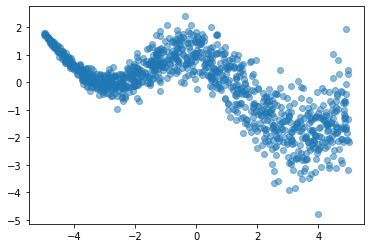

In [6]:
sample_x,sample_y = generate_batch(1024)
print(sample_x.shape,sample_y.shape)
plt.scatter(sample_x,sample_y,alpha = 0.5)

In [15]:
class Model(nn.Module):
    def __init__(self):
        super().__init__()
        
        self.ann1 = nn.Sequential(
            nn.Linear(1,10),
            nn.Tanh(),
            nn.Linear(10,1)
        )
        
        self.ann2 = nn.Sequential(
            nn.Linear(1,10),
            nn.Tanh(),
            nn.Linear(10,1)
        )
        
    def forward(self,x):
        # returns mean , log(variance)
        return self.ann1(x),self.ann2(x)

In [30]:
model = Model()
print(model)

Model(
  (ann1): Sequential(
    (0): Linear(in_features=1, out_features=10, bias=True)
    (1): Tanh()
    (2): Linear(in_features=10, out_features=1, bias=True)
  )
  (ann2): Sequential(
    (0): Linear(in_features=1, out_features=10, bias=True)
    (1): Tanh()
    (2): Linear(in_features=10, out_features=1, bias=True)
  )
)


In [31]:
def custom_criterion(outputs,targets):
    '''
    maximum likelihood error with variable variance
    '''
    mu = outputs[0]
    v = torch.exp(outputs[1])
    
    c = 0.5*torch.log(2*np.pi*v)
    f = (0.5 / v)*(targets - mu)**2
    l = torch.mean(c+f)
    
    return l

In [32]:
optimizer = torch.optim.Adam(model.parameters(),lr = 0.001)

In [33]:
n_epochs = 5000
losses = np.zeros(n_epochs)
batch_size = 128

for epoch in range(n_epochs):
    batch_x,batch_y = generate_batch(batch_size)
    x = torch.from_numpy(batch_x).float()
    y = torch.from_numpy(batch_y).float()
    
    x,y = x.view(-1,1),y.view(-1,1)
    
    optimizer.zero_grad()
    out = model(x)
    loss = custom_criterion(out,y)
    
    losses[epoch] = loss.item()
    loss.backward()
    optimizer.step()
    
    if epoch % 1000 == 0:
        print(f'epoch : {epoch} , loss : {loss.item():.4f}')

epoch : 0 , loss : 2.1202
epoch : 1000 , loss : 0.9343
epoch : 2000 , loss : 0.6841
epoch : 3000 , loss : 0.6903
epoch : 4000 , loss : 0.5672


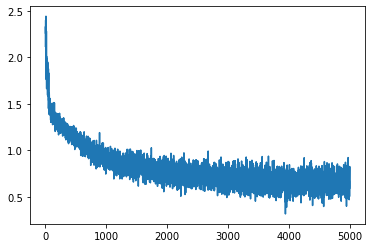

In [34]:
plt.plot(losses)

torch.Size([1024, 1]) torch.Size([1024, 1])


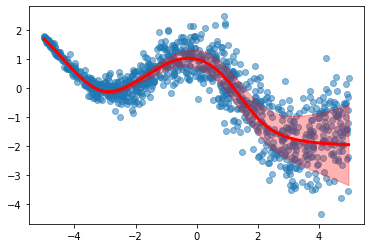

In [41]:
#making predictions

test_x_np,test_y_np = generate_batch(1024)
test_x = torch.from_numpy(test_x_np).float()
test_y = torch.from_numpy(test_y_np).float()

test_x = test_x.view(-1,1)
test_y = test_y.view(-1,1)

with torch.no_grad():
    out = model(test_x)
    print(out[0].shape,out[1].shape)
    mean_pred = out[0].numpy().flatten()
    var_pred = torch.exp(out[1]).numpy().flatten()
    
#plotting
plt.scatter(test_x_np,test_y_np,alpha = 0.5)
idx = np.argsort(test_x_np)
plt.plot(test_x_np[idx],mean_pred[idx],label = 'mean pred',linewidth = 3,color = 'red')
plt.fill_between(test_x_np[idx],mean_pred[idx] - var_pred[idx],mean_pred[idx] + var_pred[idx],color = 'red',alpha = 0.3)
plt.show()